In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import joblib
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
import seaborn as sea
%config InlineBackend.figure_format = 'retina'

In [2]:
normal_path = '/net/adv_spectrum/data/rss/downsample_10/normal/ryerson_ab_train'
fbs_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-USRP1'
cso_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver'
jamming_path = '/net/adv_spectrum/data/rss/downsample_10/abnormal/0208_anomaly'

In [13]:
def rss_autocorr(path, step=1000):
    all_corrs = []
    for file in glob.glob(path + '/*.txt'):
        rss = []
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
        if np.shape(rss)[0] > 156000:
            rss = np.array(rss).reshape(-1)[:156000]
        else:
            rss = np.array(rss).reshape(-1)[:31000]
        corrs = []
        for i in range(step, len(rss), step):
            corr = pearsonr(rss[i - step:i], rss[i:i + step])[0]
            corrs.append(corr)
        all_corrs.extend(corrs)
    return all_corrs


def rss_mean(path, step=1000):
    all_means = []
    for file in glob.glob(path + '/*.txt'):
        rss = []
        with open(file, 'r') as f:
            for line in f:
                x = line.split()
                rss.append(float(x[0]))
        if np.shape(rss)[0] > 156000:
            rss = np.array(rss).reshape(-1)[:156000]
        else:
            rss = np.array(rss).reshape(-1)[:31000]
        means = []
        for i in range(step, len(rss), step):
            mean = np.mean(rss[i - 1000:i])
            means.append(mean)
        all_means.extend(means)
    return all_means

In [14]:
jamming_corrs = rss_autocorr(jamming_path, step=1000)

In [15]:
normal_corrs = rss_autocorr(normal_path, step=1000)
fbs_corrs = rss_autocorr(fbs_path, step=1000)
cso_corrs = rss_autocorr(cso_path, step=1000)
jamming_corrs = rss_autocorr(jamming_path, step=1000)

normal_means = rss_mean(normal_path, step=1000)
fbs_means = rss_mean(fbs_path, step=1000)
cso_means = rss_mean(cso_path, step=1000)
jamming_means = rss_mean(jamming_path, step=1000)

In [17]:
X = np.concatenate((normal_means, jamming_means, fbs_means, cso_means))
X_corrs = np.concatenate((normal_corrs, jamming_corrs , fbs_corrs, cso_corrs))
y = np.concatenate((['Normal']*np.shape(normal_means)[0], ['Jamming']*np.shape(jamming_means)[0], 
                    ['FBS']*np.shape(fbs_means)[0], ['CSO']*np.shape(cso_means)[0]))

In [20]:
df_rss_corr = pd.DataFrame(X, columns=['RSS'])
df_rss_corr['corr'] = X_corrs
df_rss_corr['Type'] = y

In [21]:
df_rss_corr

RSS      corr    Type
0     -41.162957 -0.042308  Normal
1     -41.385498 -0.013338  Normal
2     -41.269331 -0.026638  Normal
3     -41.388522  0.011655  Normal
4     -41.198471 -0.013753  Normal
...          ...       ...     ...
16905 -41.205828  0.010188     CSO
16906 -41.325594  0.001825     CSO
16907 -41.236210 -0.028852     CSO
16908 -41.019465  0.083572     CSO
16909 -41.168109  0.071270     CSO

[16910 rows x 3 columns]

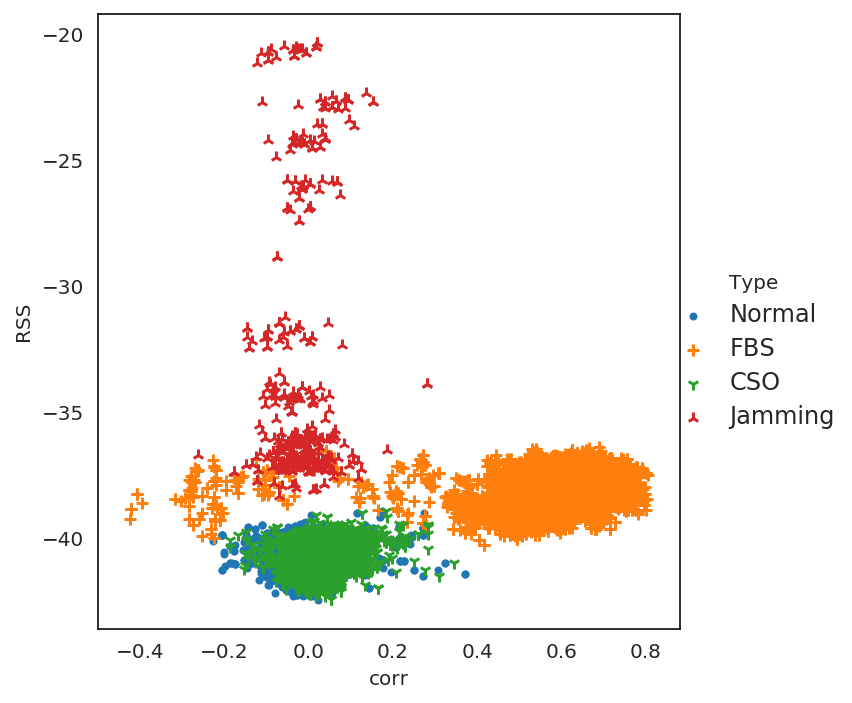

In [27]:
import seaborn as sns
df_sample = df_rss_corr.sample(frac=1, replace=True, random_state=1)
markers=['.', '+', '1', '2']
sns.set_style("white", {'axes.linewidth': 5, 'axes.edgecolor':'black'})
g = sns.lmplot(x='corr', y='RSS', markers = markers, 
           data=df_sample, hue='Type', fit_reg=False, scatter_kws={'alpha':1})
sns.despine(top=False, right=False)
plt.setp(g._legend.get_texts(), fontsize=12)
plt.show()